###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D SH finite difference modelling - Love wave propagation in the Fossa Carolina canal

After analyzing the accuracy of SH body waves and their free-surface boundary reflections in the previous lessons, we are now able to model SH surface (Love) waves. Instead of using a simplified synthetic sub-surface model, we can rely in this lesson on Full Waveform Inversion (FWI) results of a field dataset acquired across a medieval canal. The reconstructed Vs-model was verified by an archaeological excavation.

## The Fossa Carolina

One target of the Priority Program [SPP 1630 ”Harbours from the Roman Periods to the Middle Ages”](http://www.spp-haefen.de/en/home/) by the Deutsche Forschungsgemeinschaft (DFG) is the Fossa Carolina, also known as Charlemagne’s Summit Canal or Karlsgraben in German, in southern Germany. Originally initiated by the Franconian king Charlemagne, as a 3 km long canal to connect the Danube and Rhine river system and thus to overcome the central European watershed, the construction was realized in 793 AD between the rivers
Schwäbische Rezat and Altmühl. The Fossa Carolina is one of the most important large-scale hydraulic-engineering projects in the Early Middle Ages. Since 2012 the Fossa Carolina is the aim of interdisciplinary research, covering different areas like archeology, geography and geophysics. Based on a large scale magnetic prospection by the Leibniz-IPHT Jena, more detailed investigations with seismic, ground penetrating radar (GPR), electrical resistivity tomography (ERT) as well as Direct Push measurements have been conducted between 2015 and 2016. Aim of these studies was a more detailed mapping of the canal basement depth to better understand its utilization. Due to the limited penetration depth of the GPR measurements we focused on the results of first arrival traveltime tomography (FATT) and full waveform inversion (FWI) of an SH-dataset acquired along a transect of the Fossa Carolina.

The acquisition geometry comprises 47 sources and 48 horizontal component geophones with
a receiver spacing of 0.75 m and maximum offsets of 36 m. The acquired data covers a frequency band from 10 Hz to 90 Hz with high signal-to-noise (SN) ratio. Due to the high quality of the field data only a minimum of data pre-processing for the 2D FWI is required. For further details I refer to [Dokter et al. (2017)](https://www.researchgate.net/publication/317336182_Full-waveform_inversion_of_SH-_and_Love-wave_data_in_near-surface_prospecting). In this study we focused on a mono-parameter inversion of the Vs-model, while the Qs and density models are kept fixed. The initial S-wave velocity model is estimated by a FATT, while homogeneous media with Qs = 10 and density ρ = 2000 kg/m 3 are assumed. To reduce the non-linearity of the inverse
problem a sequential FWI workflow of low-pass and band-pass filtered data with different bandwidth is applied [(Köhn et al., 2018)](https://www.researchgate.net/publication/324717049_Comparison_of_time-domain_SH_waveform_inversion_strategies_based_on_sequential_low_and_bandpass_filtered_data_for_improved_resolution_in_near-surface_prospecting).

In August 2016 the Fossa Carolina canal was excavated along the 2D seismic SH-profile. The derived sketches and photos allow a unique opportunity to directly compare the FWI results with the true structures visible in the subsurface. The photo below taken during the excavation shows a 5.4 m long part of the Fossa Carolina canal between 18.6
m and 24.0 m along the 2D SH-profile down to a depth of 1.8 m. 

<img src="images/FATT_FWI_comp_photo_final.jpg" width="100%">

It shows gradual transitions between the layers, except for the very sharp definition of the canal basement. The upper 40 cm of the depth-cut show a weathering layer consisting of soil and vertical cracks. With increasing depth alternating, distinct yellowish and grey clay layers are visible. Near the bottom of the excavation, parts of the black organic-rich layer are uncovered. For a direct comparison of the FWI result, we superimposed image and contour plots of the Vs-models on the excavation photo. The FWI result shows an improved definition of the canal basement by the dense velocity contours, indicating a significant velocity gradient. In contrast to a classical First Arrival Traveltime Tomograpy (FATT), some distinct low- and high velocity anomalies appear within the canal ([Köhn et al., 2018](https://www.researchgate.net/publication/324717049_Comparison_of_time-domain_SH_waveform_inversion_strategies_based_on_sequential_low_and_bandpass_filtered_data_for_improved_resolution_in_near-surface_prospecting), [Köhn et al., 2018a](https://www.researchgate.net/publication/325696342_2D_full_waveform_inversion_applied_to_a_strongly-dispersive_Love_wave_field_dataset_talk)). In some parts, colors of the photo can be directly correlated with the velocity model. For example, the low-velocity contour lines of the FWI Vs-model nearly coincide with the deep yellowish clay layer, the high velocity anomaly above correlates with the grey clay layer. In the weathering layer this correlation is not so clear anymore, because the loose soil and deep-penetrating
vertical cracks lead to a reduction of the shear modulus. As a result some dominant near surface low-velocity anomalies down to a depth of 40 cm are introduced.

For the derived Fossa Carolina S-wave velocity model, we will now calculate propagation and dispersion of Love waves ... 

In [2]:
# Import Libraries 
# ----------------
import numpy as np
from numba import jit
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

As usual, we first define the modelling parameters ...

In [3]:
# Definition of modelling parameters
# ----------------------------------
nx = 744  # number of spatial gridpoints in x-direction
nz = 120  # number of spatial gridpoints in z-direction

dx = 0.05 # spatial gridpoint distance in x-direction
dz = dx   # spatial gridpoint distance in z-direction

# Define model filename
name_vs = "Fossa_Carolina/Fossa_Carolina_LBL.vs"

tmax = 0.5   # maximum recording time of the seismogram (s)

# acquisition geometry
xr = 25.5     # x-receiver position (m)
zr = 0.05     # z-receiver position (m)

xsrc = 17.5   # x-source position (m)
zsrc = 0.05    # z-source position (m)

f0   = 40. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift (s)

isnap = 4  # snapshot interval (timesteps)

... load the Fossa Carolina S-wave velocity model ...

In [4]:
# Open file and write binary data to vp
f = open(name_vs)
data_type = np.dtype ('float32').newbyteorder ('<')
vs = np.fromfile (f, dtype=data_type)

# Reshape (1 x nx*nz) vector to (nx x nz) matrix 
vs = vs.reshape(nx,nz)

... and take a look at the Fossa Carolina model:

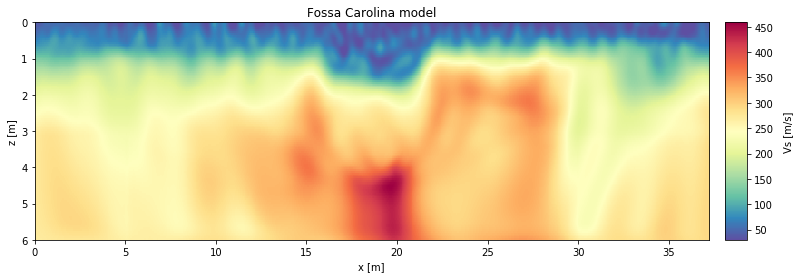

In [5]:
# Plot Fossa Carolina vs-model
# ----------------------------

# Define xmax, zmax and model extension
xmax = nx * dx
zmax = nz * dz
extent = [0, xmax, zmax, 0]

fig = plt.figure(figsize=(15,4))  # define figure size

image = plt.imshow((vs.T), cmap=plt.cm.Spectral_r, interpolation='nearest', 
                   extent=extent, aspect=2)

cbar = plt.colorbar(aspect=10, pad=0.02)
cbar.set_label('Vs [m/s]', labelpad=10)
plt.title('Fossa Carolina model')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.show()

Notice the low velocity layer on top of the model and small scale features within the canal, which could be partly correlated with the archaeological excavation photo. Beside the Vs model, the FD code also requires a density model. Due to the low impact of the density model, we can use a simple homogeneous density model with $\rho = 1800\; kg/m^3$ typical for near-surface soil...

In [6]:
rho = 1800.0 * (vs / vs)

In the next step, we define the update functions for particle velocity $v_y$ ...

In [7]:
# Particle velocity vy update
# ---------------------------
@jit(nopython=True) # use JIT for C-performance
def update_vel(vy, syx, syz, dx, dz, dt, nx, nz, rho):
    
    # 2nd order FD operator   
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):

            # Calculate spatial derivatives  (2nd order operator)           
            syx_x = (syx[i,j] - syx[i - 1,j]) / dx
            syz_z = (syz[i,j] - syz[i,j - 1]) / dz

            # Update particle velocities
            vy[i,j] = vy[i,j] + (dt/rho[i,j]) * (syx_x + syz_z)                               
                
    return vy

... updating the shear stress components $\sigma_{yx}$ and $\sigma_{yz}$ ...

In [8]:
# Shear stress syx, syz updates
# -----------------------------
@jit(nopython=True) # use JIT for C-performance
def update_stress(vy, syx, syz, dx, dz, dt, nx, nz, mux, muz):
    
    # 2nd order FD operator
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):

            # Calculate spatial derivatives (2nd order operator)
            vy_x = (vy[i + 1,j] - vy[i,j]) / dx
            vy_z = (vy[i,j + 1] - vy[i,j]) / dz

            # Update shear stresses
            syx[i,j] = syx[i,j] + dt * mux[i,j] * vy_x
            syz[i,j] = syz[i,j] + dt * muz[i,j] * vy_z                    
    
    return syx, syz

... and harmonically averaging the shear modulus ...

In [9]:
# Harmonic averages of shear modulus
# ----------------------------------
@jit(nopython=True) # use JIT for C-performance
def shear_avg(mu, nx, nz, mux, muz):
    
    for i in range(1, nx - 1):
        for j in range(1, nz - 1):
            
            # Calculate harmonic averages of shear moduli        
            mux[i,j] = 2 / (1 / mu[i + 1,j] + 1 / mu[i,j])
            muz[i,j] = 2 / (1 / mu[i,j + 1] + 1 / mu[i,j])
            
    return mux, muz

To avoid boundary reflections from the bottom as well as left and right boundary, we use the simple Sponge boundary frame, which was introduced for the 2D acoustic code in [this lesson](http://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/05_2D_acoustic_FD_modelling/4_fdac2d_absorbing_boundary.ipynb):

In [10]:
# Define simple absorbing boundary frame based on wavefield damping 
# according to Cerjan et al., 1985, Geophysics, 50, 705-708
def absorb(nx,nz):

    FW = 60     # thickness of absorbing frame (gridpoints)    
    a = 0.0053
    
    coeff = np.zeros(FW)
    
    # define coefficients in absorbing frame
    for i in range(FW):    
        coeff[i] = np.exp(-(a**2 * (FW-i)**2))

    # initialize array of absorbing coefficients
    absorb_coeff = np.ones((nx,nz))

    # compute coefficients for left grid boundaries (x-direction)
    zb=0 
    for i in range(FW):
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[i,j] = coeff[i]

    # compute coefficients for right grid boundaries (x-direction)        
    zb=0
    for i in range(FW):
        ii = nx - i - 1
        ze = nz - i - 1
        for j in range(zb,ze):
            absorb_coeff[ii,j] = coeff[i]

    # compute coefficients for bottom grid boundaries (z-direction)        
    xb=0 
    for j in range(FW):
        jj = nz - j - 1
        xb = j
        xe = nx - j
        for i in range(xb,xe):
            absorb_coeff[i,jj] = coeff[j]

    return absorb_coeff

Finally, we assemble all parts into the 2D SH FD code:

In [11]:
# 2D SH Wave Propagation (Finite Difference Solution) 
# ---------------------------------------------------
def FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc,vs,rho):        
            
    nt = (int)(tmax/dt) # maximum number of time steps            
    print('nt = ',nt)
    
    ir = (int)(xr/dx)      # receiver location in grid in x-direction    
    jr = (int)(zr/dz)      # receiver location in grid in z-direction

    # Source time function (Gaussian)
    # -------------------------------
    src  = np.zeros(nt + 1)
    time = np.linspace(0 * dt, nt * dt, nt)

    # 1st derivative of a Gaussian
    src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

    # define wavefield clip value    
    clip = 1e-5
    
    # Initialize coordinates
    # ----------------------
    x    = np.arange(nx)
    x    = x * dx       # coordinates in x-direction (m)

    z    = np.arange(nz)
    z    = z * dz       # coordinates in z-direction (m)
    
    # calculate 2D Green's function for direct SH wave from source position    
    isrc = (int)(xsrc/dx)  # source location in grid in x-direction
    jsrc = (int)(zsrc/dz)  # source location in grid in x-direction            
    
    # Initialize empty pressure arrays
    # --------------------------------
    vy    = np.zeros((nx,nz)) # particle velocity vy
    syx   = np.zeros((nx,nz)) # shear stress syx
    syz   = np.zeros((nx,nz)) # shear stress syz        
    
    # define shear modulus
    # --------------------
    mu = rho * vs**2
    
    # harmonic average of shear moduli
    # --------------------------------
    mux   = mu # initialize harmonic average mux 
    muz   = mu # initialize harmonic average muz

    mux, muz = shear_avg(mu, nx, nz, mux, muz)
    
    # Initialize empty seismogram
    # ---------------------------
    seis = np.zeros(nt) 
    
    # Define absorbing boundary frame
    # -------------------------------    
    absorb_coeff = absorb(nx,nz)
    
    # Initalize animation of vy wavefield 
    # -----------------------------------
    fig = plt.figure(figsize=(7,3))  # define figure size
    extent = [0.0,xmax,zmax,0.0]     # define model extension
    
    # Plot Vp-model
    image = plt.imshow((vs.T), cmap=plt.cm.gray, interpolation='nearest', 
                        extent=extent, aspect=2)    
    
    # Plot vy wavefield movie
    image1 = plt.imshow(vy.T, animated=True, cmap="RdBu", alpha=.75, extent=extent, 
                          interpolation='nearest', aspect=2, vmin=-clip, vmax=clip)
    
    plt.title('Vy wavefield')
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
           
    plt.ion()    
    plt.show(block=False)
    
    # Time looping
    # ------------
    for it in range(nt):
    
        # Update particle velocity vy
        # ---------------------------
        vy = update_vel(vy, syx, syz, dx, dz, dt, nx, nz, rho)

        # Add Source Term at (isrc,jsrc)
        # ------------------------------
        # Absolute particle velocity w.r.t analytical solution
        vy[isrc,jsrc] = vy[isrc,jsrc] + (dt * src[it] / (rho[isrc,jsrc] * dx * dz))
        
        # Apply absorbing boundary frame to vy
        # ------------------------------------
        vy *= absorb_coeff        
        
        # Update shear stress syx, syz
        # ----------------------------
        syx, syz = update_stress(vy, syx, syz, dx, dz, dt, nx, nz, mux, muz)                
        
        # Apply absorbing boundary frame to syx, syz
        # ------------------------------------------
        syx *= absorb_coeff
        syz *= absorb_coeff
        
        # Output of Seismogram
        # -----------------
        seis[it] = vy[ir,jr]
        
        # display vy snapshots 
        if (it % isnap) == 0:            
            image1.set_data(vy.T)
            fig.canvas.draw()
        
    return time, seis

We start with the modelling of the wave propagation and seismogram for a homogeneous model with the average S-wave velocity of the Fossa Carolina model and constant density $\rho = 1800\; kg/m^3$ 

nt =  3369


<IPython.core.display.Javascript object>


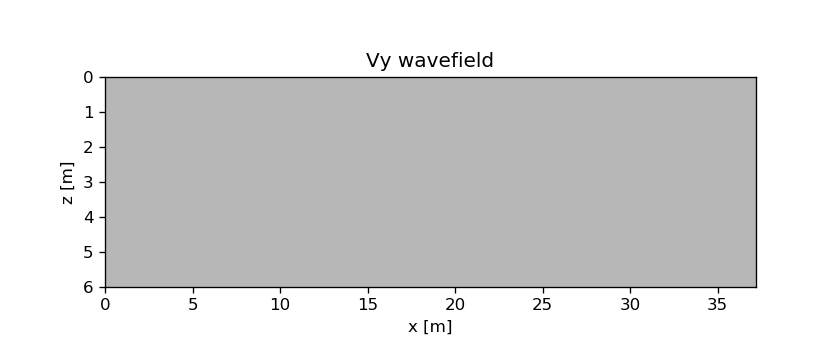

In [12]:
# Run SH FD modelling for homogeneous model
# -----------------------------------------
%matplotlib notebook

# define homogeneous model
vs0 = np.mean(vs) * (vs / vs)
rho0 = 1800.0 * (vs / vs)

# calculate time step according to CFL criterion
dt = dx / (np.sqrt(2) * np.max(vs0)) 

time, seis_hom = FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc,vs0,rho0)

<IPython.core.display.Javascript object>


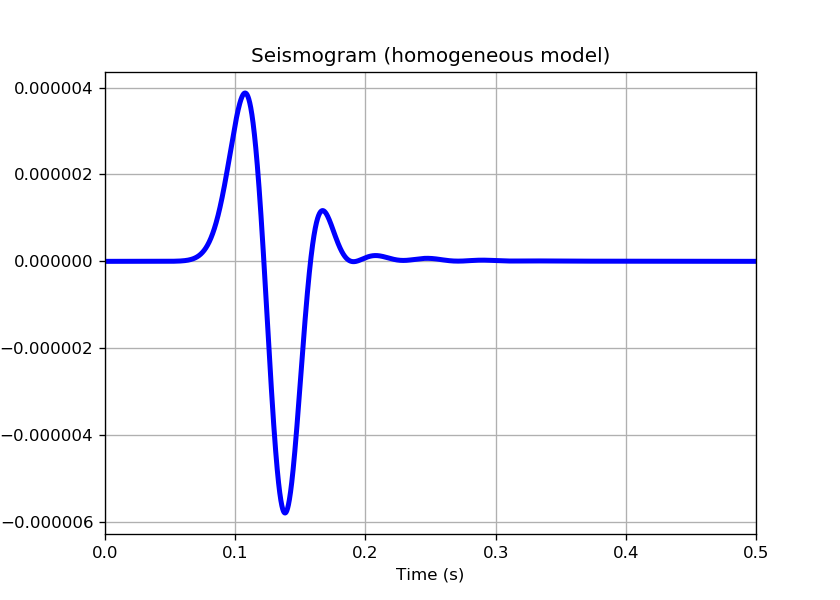

In [13]:
# Plot FD Seismogram
# ------------------
%matplotlib notebook
# Define figure size
rcParams['figure.figsize'] = 7, 5
plt.plot(time, seis_hom, 'b-',lw=3,label="FD solution") # plot FD seismogram
plt.xlim(time[0], time[-1])
plt.title('Seismogram (homogeneous model)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

Even though the model contains a free surface, no Love wave propagates in the homogeneous model. We only see the direct SH body wave. One way to understand the origin and propagation of Love waves is by the interference of SH body waves in a layered medium, which explains why no Love waves propagate in a homogeneous medium. A mathematically more detailed description of the problem was given in the "Theory of Seismic Waves" lecture [(Müller 2007)](http://gfzpublic.gfz-potsdam.de/pubman/item/escidoc:8728:5/component/escidoc:8727/0703.pdf).

So let's turn to the heterogeneous Fossa Carolina canal model, where the seismic wavefield should be dominated by Love waves:

nt =  6487


<IPython.core.display.Javascript object>


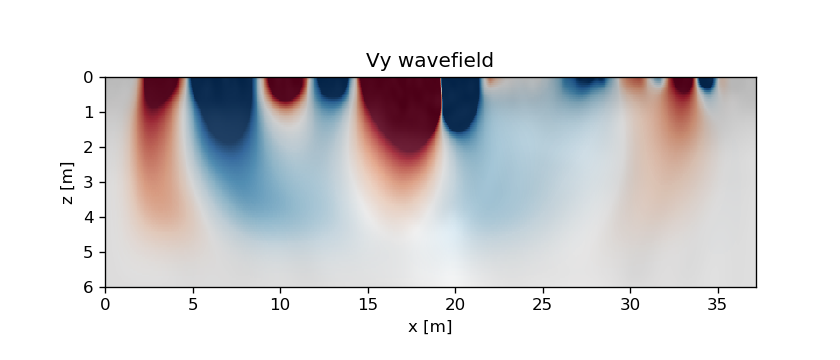

In [14]:
# Run SH FD modelling for heterogeneous Fossa Carolina canal model
%matplotlib notebook
# calculate time step according to CFL criterion
dt = dx / (np.sqrt(2) * np.max(vs)) 

time, seis_fossa = FD_2D_SH_JIT(dt,dx,dz,f0,xsrc,zsrc,vs,rho)

<IPython.core.display.Javascript object>


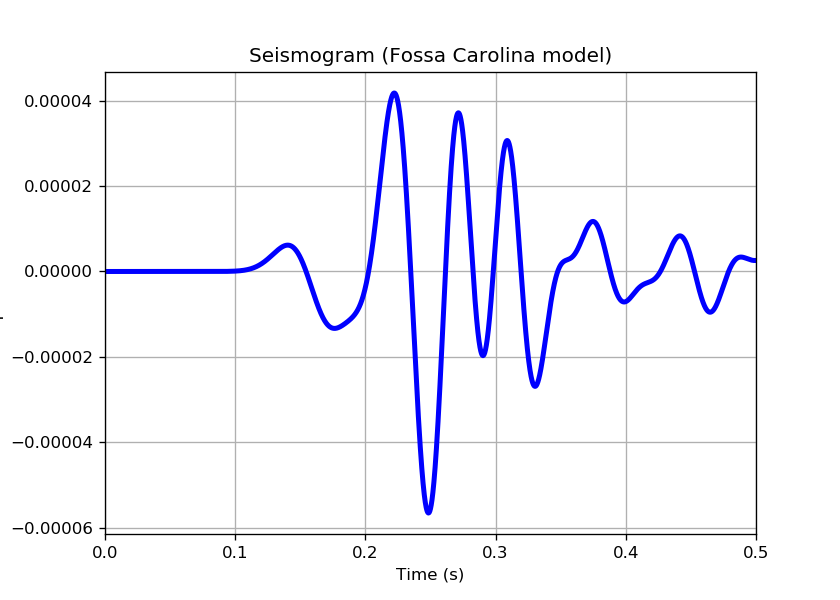

In [15]:
# Plot FD Seismogram
# ------------------
%matplotlib notebook
# Define figure size
rcParams['figure.figsize'] = 7, 5
plt.plot(time, seis_fossa, 'b-',lw=3,label="FD solution") # plot FD seismogram
plt.xlim(time[0], time[-1])
plt.title('Seismogram (Fossa Carolina model)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

Wow, a quite impressive, dispersive Love wave sticking to the free-surface on top of the model, penetrating down to a depth of 3 m for the low-frequency part, while the high frequency Love waves propagate in the upper 1 m. Notice also the amplitude differences in the seismograms for the direct SH body wave (6e-6 m/s) in the homogeneous model and the Love wave (6e-5 m/s) in the heterogeneous Fossa Carolina canal.

##### Excercise

You might wonder why we used such a simple homogeneous density model despite the heterogeneous sub-surface. To investigate the impact of a realistic heterogeneous density model on the Love-wavefield, compute a heterogeneous density model for the Fossa Carolina canal based on the Vs-model with an empirical density $\rho$ - S-wave velocity model $V_s$ relation from [Ulugergerli & Uyanık (2007)](https://www.researchgate.net/publication/249958795_Statistical_Correlations_Between_Seismic_Wave_Velocities_and_SPT_Blow_Counts_and_the_Relative_Density_of_Soils):

\begin{equation}
\rho = 0.1055\; ln(V_s)\; +\; 1.3871\notag
\end{equation}

with the units for $V_s$ $[m/s]$ and density $\rho$ $[g/cm^3]$. Compute the Love-/SH-wavefield for the Fossa Carolina canal model with the heterogeneous density model and compare the resulting seismograms with the previous result for the homogeneous density model. Discuss differences and similarities.

## What we learned:

* Implementation of the simple Sponge boundary for the 2D SH-problem
* Love waves do not propagate in a homogeneous SH medium
* Dispersive Love waves propagte in the heterogeneous Fossa Carolina canal model, where the penetration depth is frequency dependent